## Univariate Model

After collecting the data, I want to get baseline results by seeing how much predictive power previous levels of HPI have on predicting future HPI.

I will train and assess a variety of models separately for each city, including simple AR, ARMA, and ARIMA.

#### Importing Packages

In [2]:
import pandas as pd
import numpy as np
import requests
import json
import os
import time
import fred_msa
import ts_functions
import datetime as dt
from datetime import date
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

#### Ingesting Data

In [3]:
hpi = pd.read_csv('..\\working-data\\hpi-data.csv')
hpi = hpi.query("year <= 2019")
hpi.date = pd.to_datetime(hpi.date)
#hpi = hpi.set_index(['city', 'msa_state', 'date'])

#### Examine Stationarity Using the Augmented Dickey-Fuller Test

"Stationarity" is the property of a time series that the mean and variance are constant over time (e.g. an extreme example would be a sine curve). Many basic time series models assume stationarity, so we want to determine whether these will be feasible for this problem, or if we will need to use more advanced statistical models. Based on working knowledge of the housing market I would assume there is *not* stationarity, but I want to test this assumption using the Dickey-Fuller test, a standard test for stationarity.

In [4]:
adf_p = {}
for city in hpi.city.unique():
    adf_p[city] = adfuller(hpi[hpi.city==city].hpi)[1]

In [5]:
adf_df = pd.DataFrame(adf_p, index=['adf_pval']).T
adf_df.style.background_gradient(cmap = 'YlGnBu')

Surprisingly, a few cities are showing $p < 0.1$ for this test, implying that they fit the criteria for stationarity. I will examine these cities in more detail.

In [6]:
cities_to_examine = ['Charleston', 'Rockford', 'Trenton']

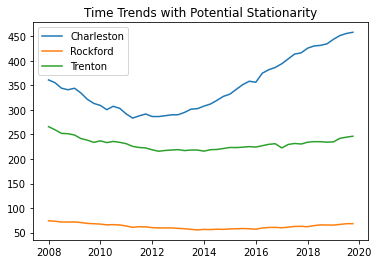

In [7]:
for city in cities_to_examine:
    plt.plot(hpi[hpi.city==city].set_index(['date']).hpi, label=city)
plt.legend()
plt.title('Time Trends with Potential Stationarity')
plt.show()

While the mean and variance look largely consistent for these cities, each of them follows a similar trend of dipping during and following the 2008 recession, then rising again afterwards. This matches the trend for other cities, so we can safely assume that despite the ADF results, **these trends are non-stationary.**

#### Examine Full and Partial Autocorrelation

In [8]:
ac_vals = []
pac_vals = []
for x in range (1, 21):
    ac_vals.append(hpi.groupby(['city'])['hpi'].apply(pd.Series.autocorr, lag=x).mean())
    pac_vals.append(hpi.groupby(['city'])['hpi'].apply(pacf, nlags=x).mean()[-1])

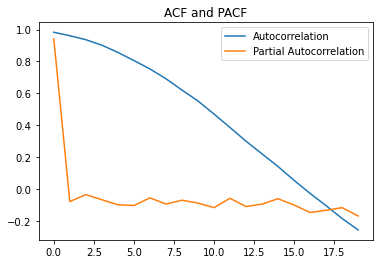

In [9]:
plt.plot(ac_vals, label='Autocorrelation')
plt.plot(pac_vals, label='Partial Autocorrelation')
plt.title('ACF and PACF')
plt.legend()
plt.show()

**As expected, we see a steep decline in partial autocorrelation (correlation of error) and a gradual, semi-linear decline in autocorrelation. This implies that we can test higher orders of $p$ in our ARIMA model, but should limit ourselves to low $q$.** 

**For this problem, I will test $p \in [1,4]$, $d \in [0,2]$ and $q \in [0,1]$**

#### Run  Modeling - Statistical Methods

In [10]:
arima_results = pd.DataFrame()

for city in hpi.city.unique():
    for p in range(1,5):
        for d in range(1,3):
            for q in range(0, 2):

                func_result = ts_functions.ARIMA_pred(hpi, city, (p,d,q), trend='n')
                func_result['city'] = city
                func_result['p'] = p
                func_result['d'] = d
                func_result['q'] = q
                arima_results = pd.concat([arima_results, func_result])

KeyboardInterrupt: 

In [10]:
arima_results.to_csv('../model-results/arima_results.csv')

#### Evaluate Results

This evaluation measures four things:
1. win rate - the proportion of times the prediction beats the naive assumption $x_{t+k} = x_t \forall k$, measured across prediction periods 1-4
2. error - the average MSE across prediction periods 1-4
3. improvement - the average MSE improvement over the naive assumption across periods 1-4
4. AIC - Akike's Information Criterion, a complexity-penalized measure of goodness of fit
5. p value - the median p value for parameters in the model

In [11]:
arima_results = pd.read_csv('../model-results/arima_results.csv')

In [12]:
model_evaluation = ts_functions.evaluate_model(arima_results, method='square')

In [13]:
best_results = ts_functions.ARIMA_best_hypers(arima_results, model_evaluation)

## Analysis of Results

#### Question 1 - How can we evaluate model accuracy and usefulness?

When performing model selection, we examined several different measures of model accuracy, including MSE, MSE improvement over the naive hypothesis, AIC, and median p value of the model parameters. It will be helpful to see how these variables relate to each other first to examine some of the tradeoffs.

In [22]:
best_hypers = best_results.groupby(['city'])['p', 'd', 'q'].first().reset_index()

In [24]:
best_model_results = model_evaluation.merge(best_hypers, how='inner', on=['city', 'p', 'd', 'q'], validate = 'one_to_one')

In [25]:
best_model_results['n_params'] = best_model_results.p + best_model_results.d + best_model_results.q

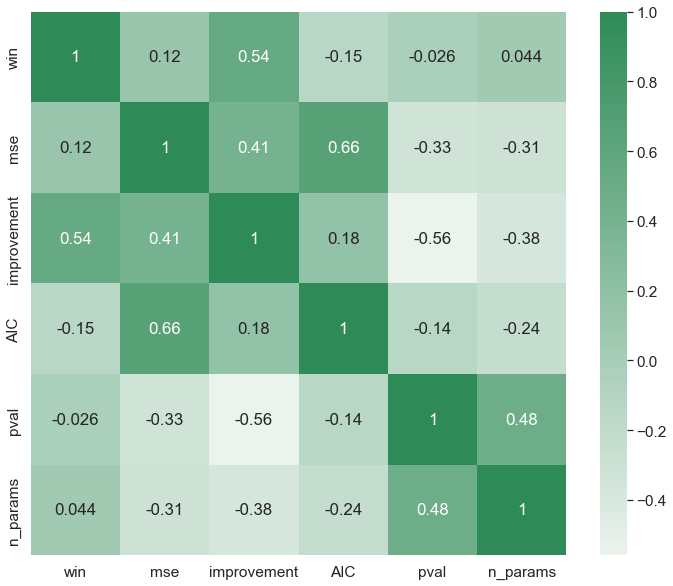

In [26]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(best_model_results.drop(columns=['city', 'p', 'd', 'q']).corr(), cmap=sns.light_palette("seagreen", as_cmap=True), annot=True)
plt.show()

It appears that AIC and MSE are highly correlated, as are MSE and MSE improvement (which makes a lot of sense). One interesting observation is the relationship between p values and the number of model parameters - as the number of parameters goes up, the median p value tends to be higher. Additionally, p values are negatively correlated with all other measures of model effectiveness. Keeping in mind that we are only looking at the *best* models for each city, this probably means that p value is not a useful statistic. If a large-parameter model beats out a simpler one, that means that it is a more useful one *despite* the higher p value. 

For that reason we will look at MSE, MSE improvement, and AIC to determine model accuracy and usefulness.

#### Question 2 - For which cities can we predict HPI best as a univariate time series?

Before determining any objective measure of how "predictable" HPI is using past values, it will be helpful to do a subjective comparison of our various cities based on the metrics discussed above.

**MSE - Rankings and Charts of Top 3 and Bottom 3 MSE cities**

In [27]:
best_model_results.sort_values('mse').style.background_gradient(cmap = 'YlGnBu', gmap=best_model_results.mse)

Top Cities

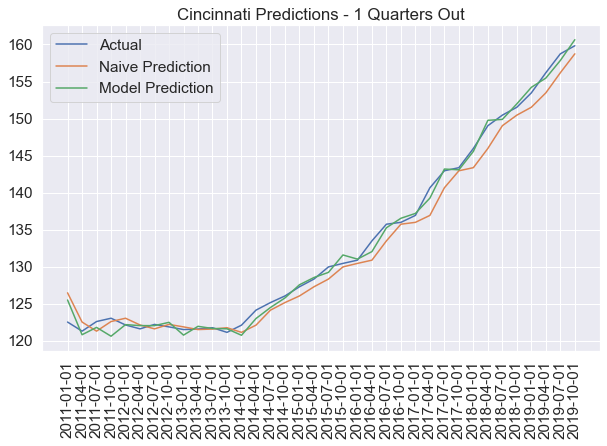

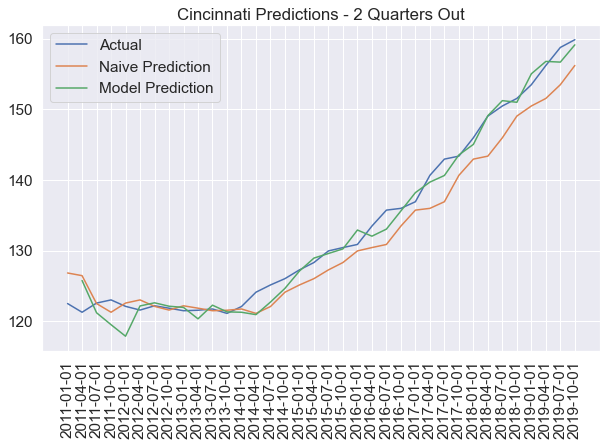

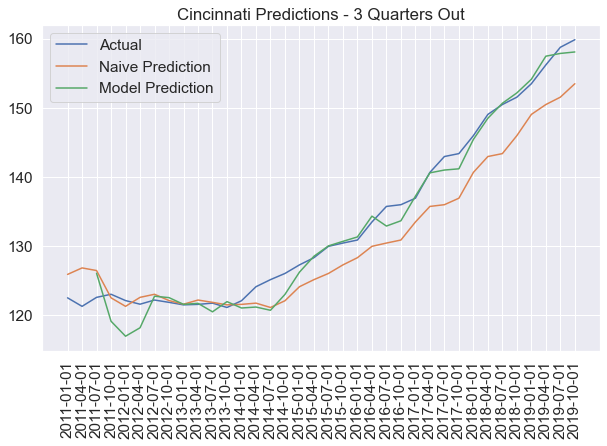

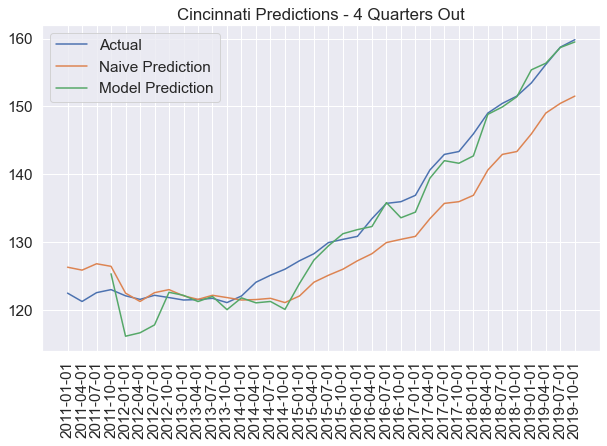

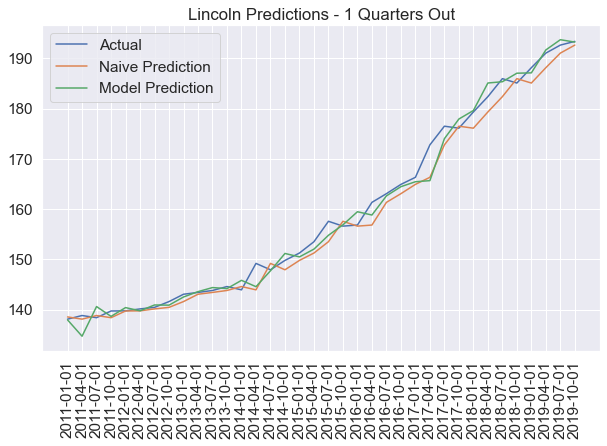

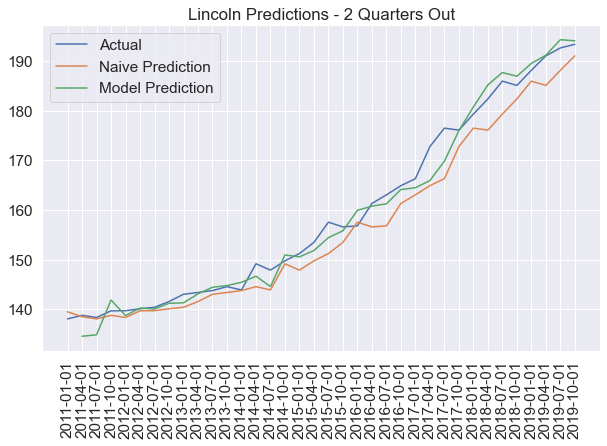

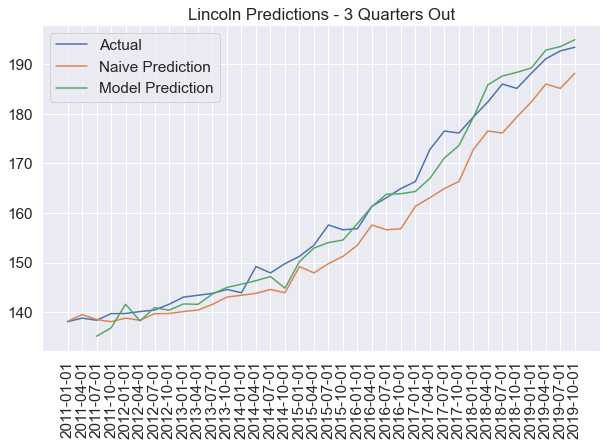

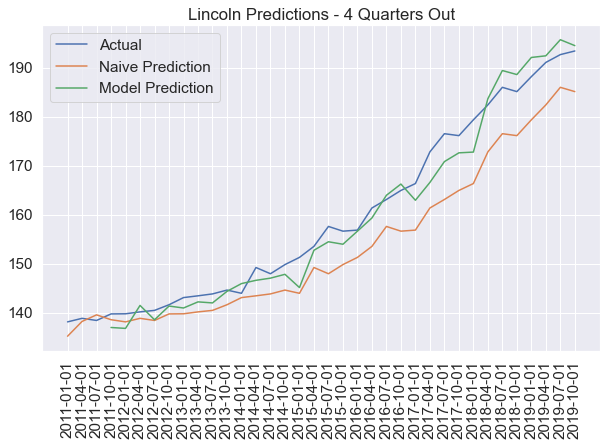

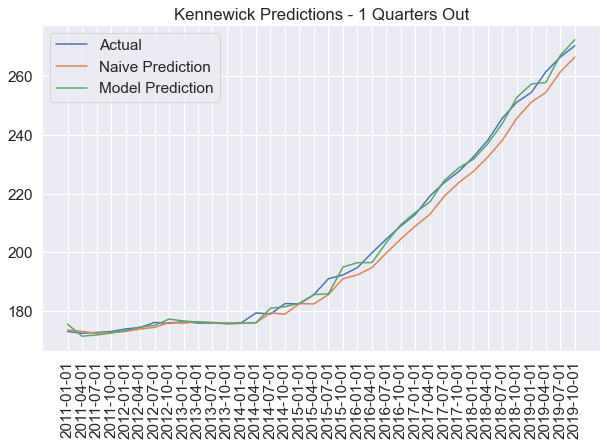

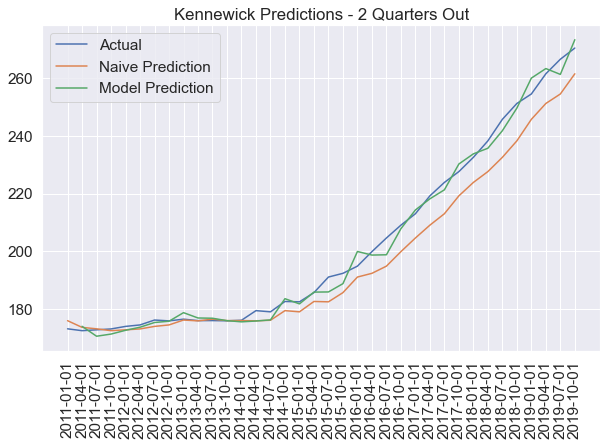

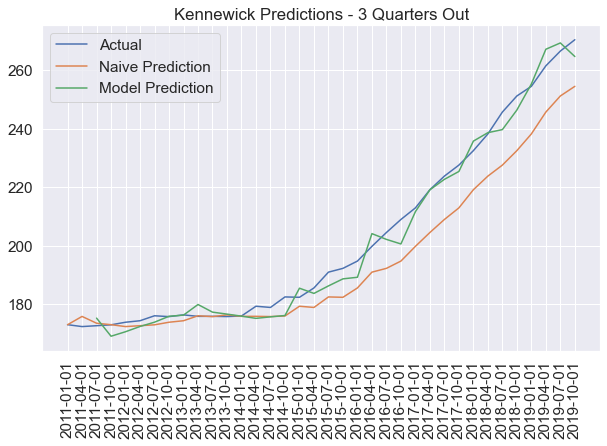

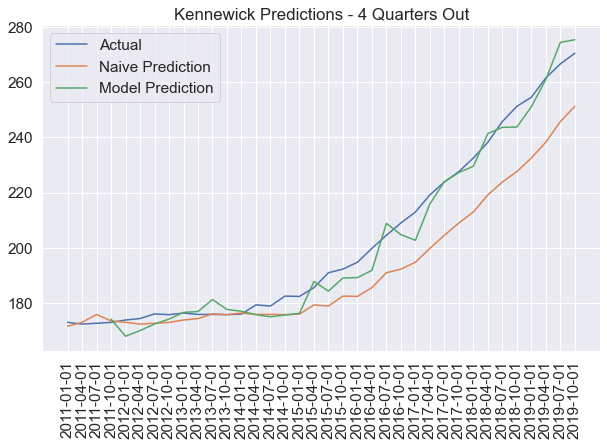

In [59]:
for city in best_model_results.sort_values('mse').head(3).city:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.date, city_df.hpi,  label='Actual')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

Bottom 3

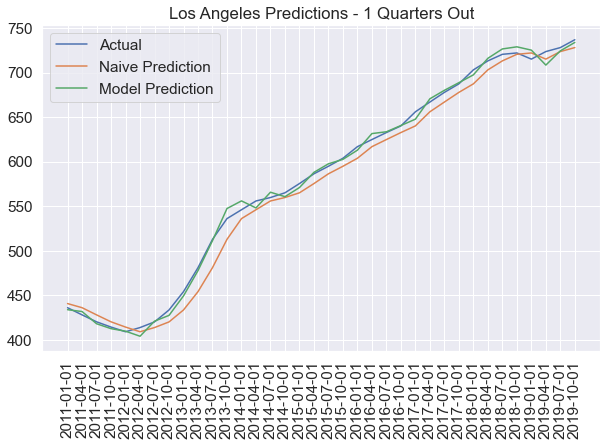

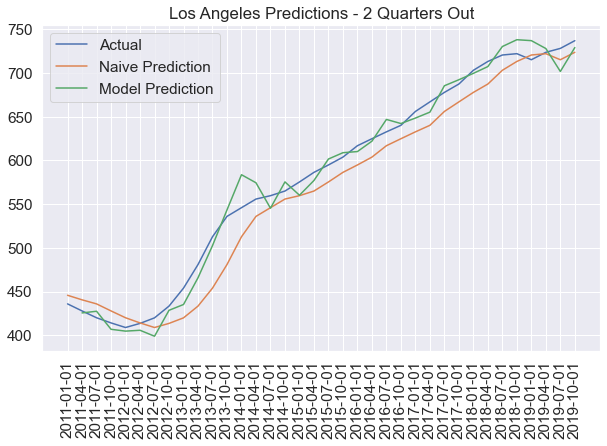

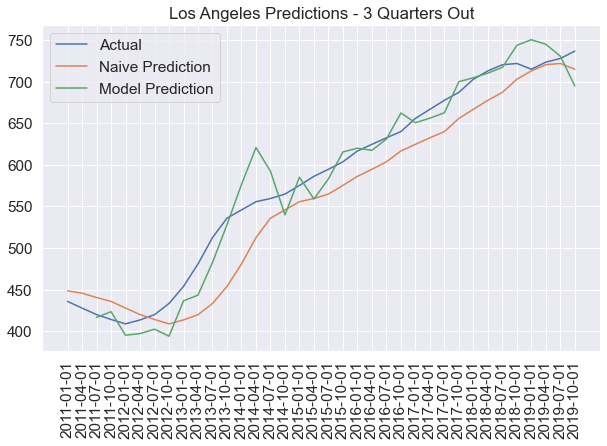

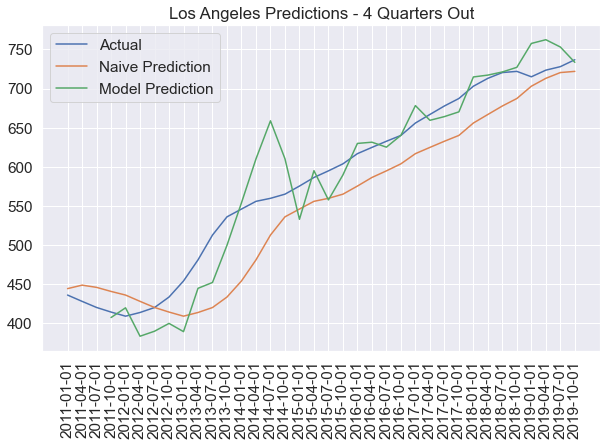

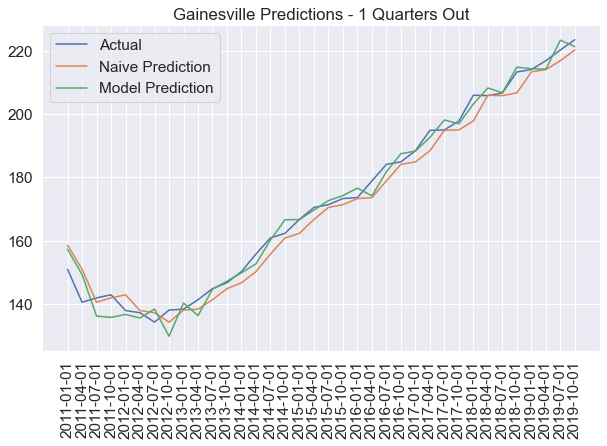

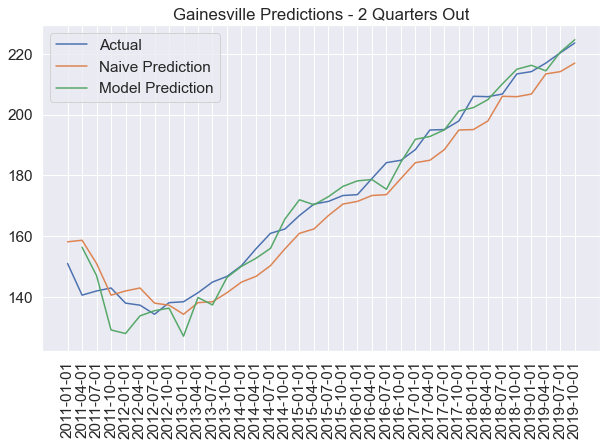

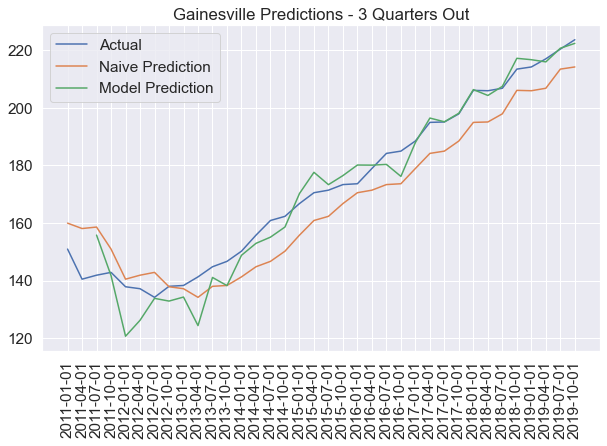

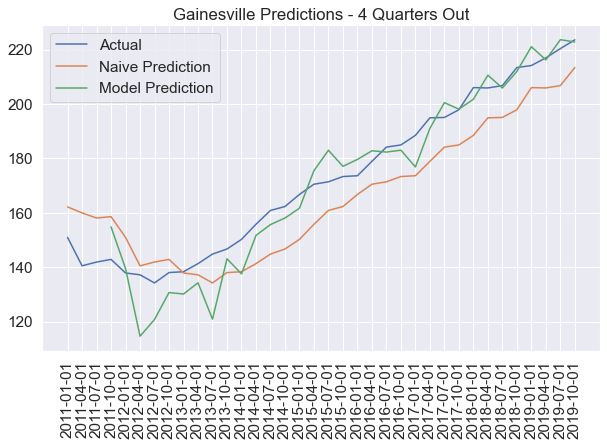

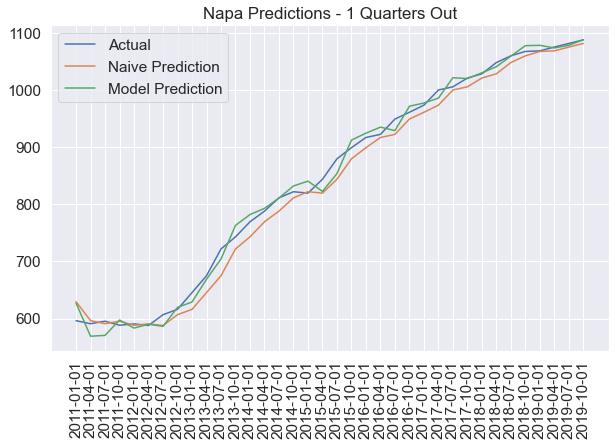

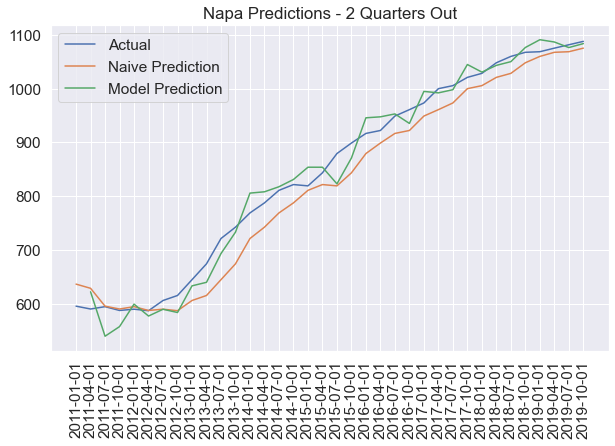

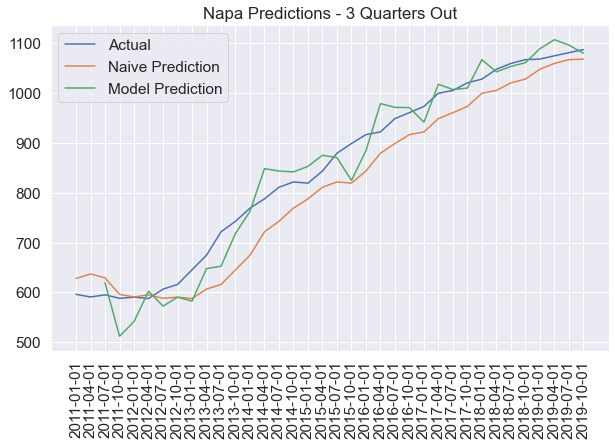

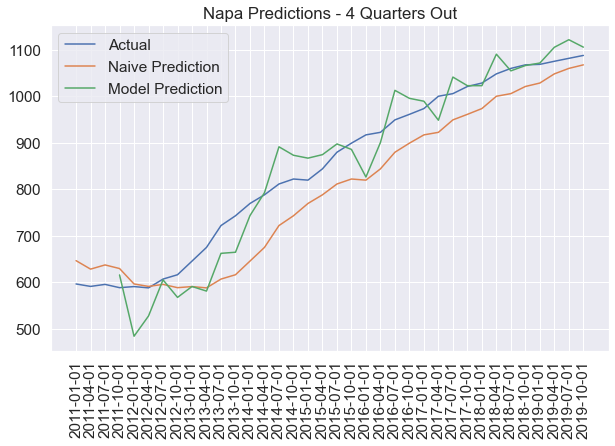

In [60]:
for city in best_model_results.sort_values('mse').tail(3).city:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.date, city_df.hpi,  label='Actual')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

The main takeaway with MSE here is that time outlook makes a lot of difference. Both the "best" and "worst" models tend to provide fairly close (and seemingly better than naive) predictions one quarter out, but what really differentiates them is their ability to project 3 and 4 quarters out. Interesntingly, both cities show fairly consistent trends from around 2012 onward. The difference is that the "good" models seem to stick more to this trend, while the "bad" models over-react to period-by-period changes. This actually makes sense when considering the order of autoregression - the best models have more paramters, while it seems that in the cities that are hardest to model (in terms of MSE), other factors may be at play.

**MSE Improvement**

In [54]:
best_model_results['naive_mse'] = best_model_results.mse + best_model_results.improvement
best_model_results['improvement_pct'] = best_model_results.improvement/best_model_results.naive_mse

In [55]:
best_model_results.sort_values('improvement_pct', ascending=False).style.background_gradient(cmap = 'YlGnBu', gmap=best_model_results.improvement_pct)

Top Cities

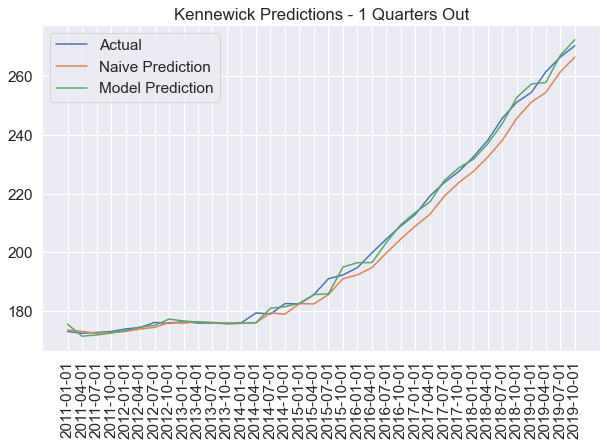

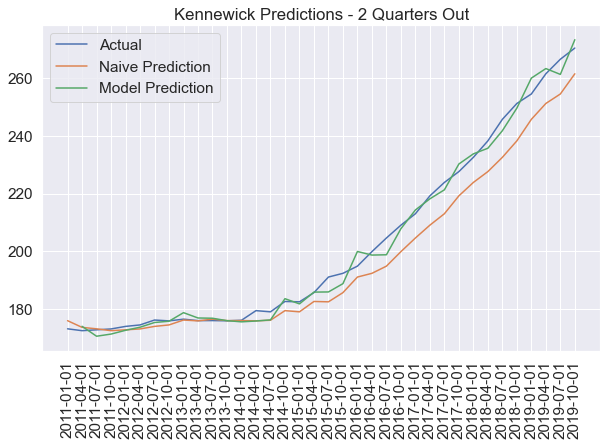

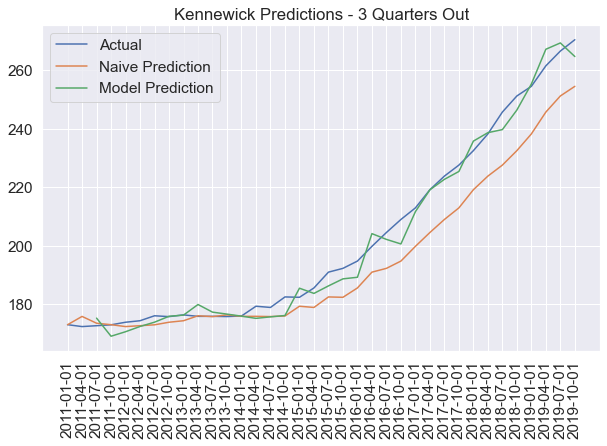

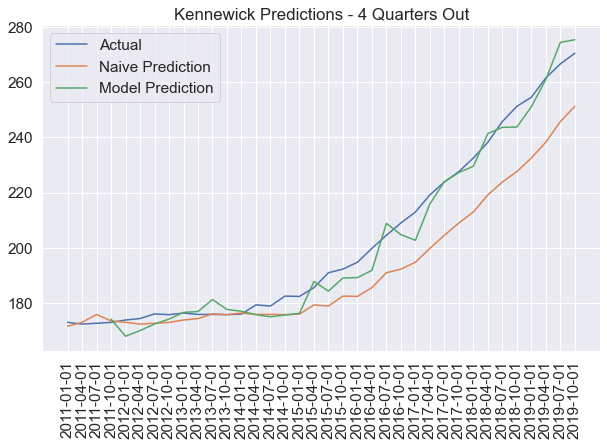

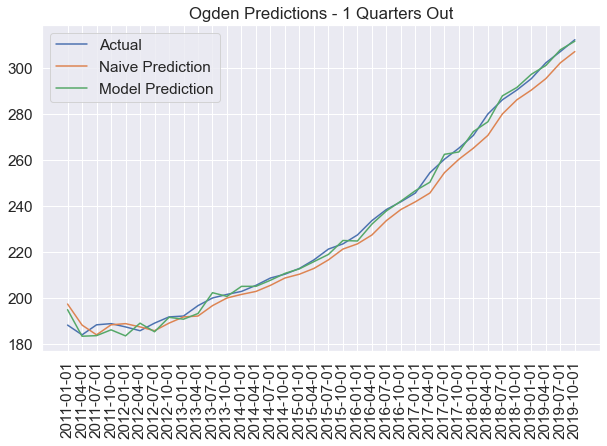

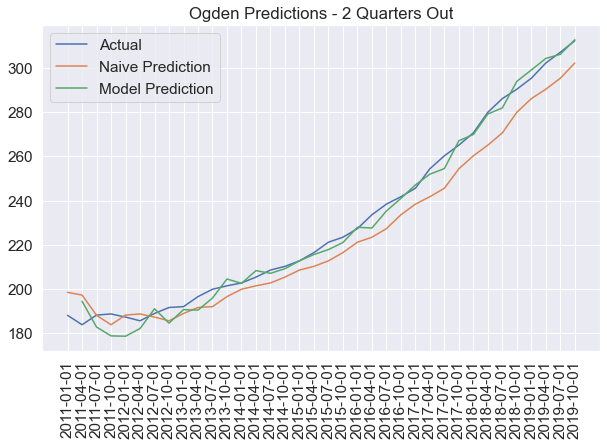

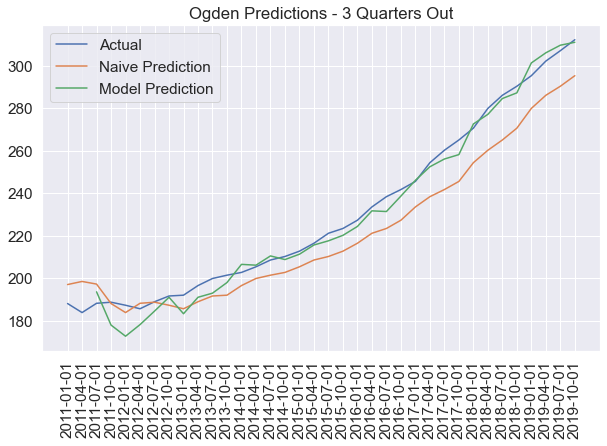

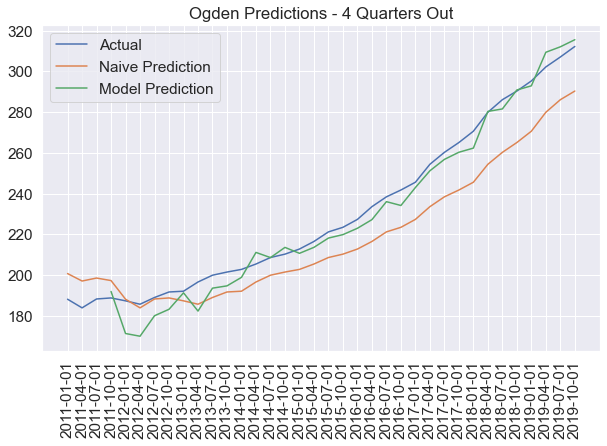

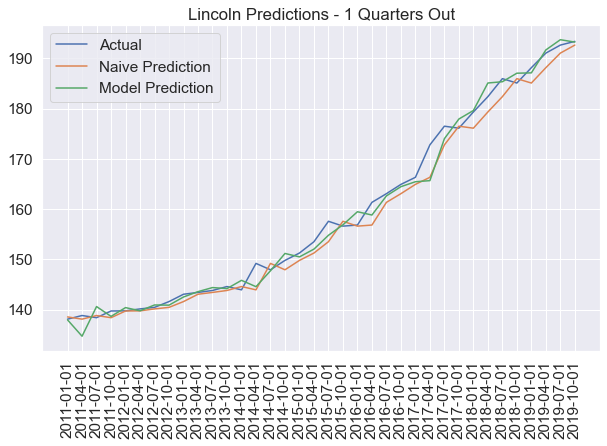

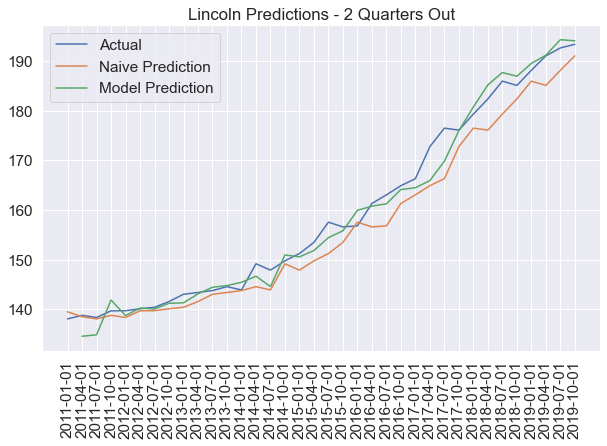

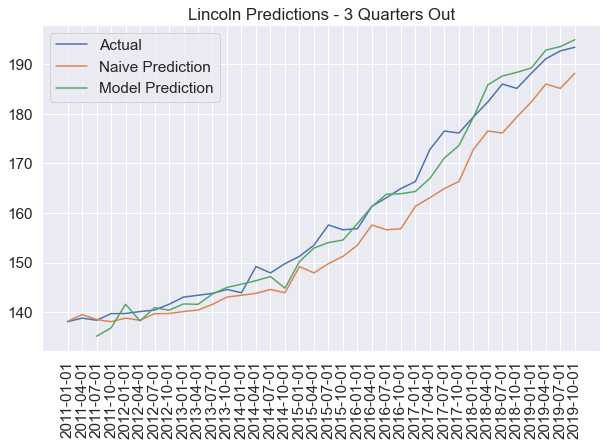

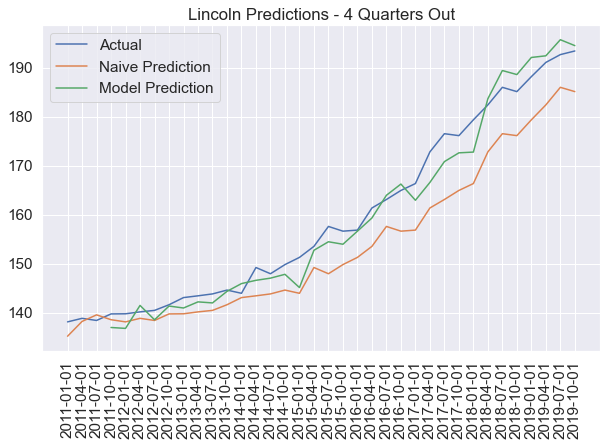

In [61]:
for city in best_model_results.sort_values('improvement_pct', ascending=False).head(3).city:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.date, city_df.hpi,  label='Actual')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

Bottom Cities

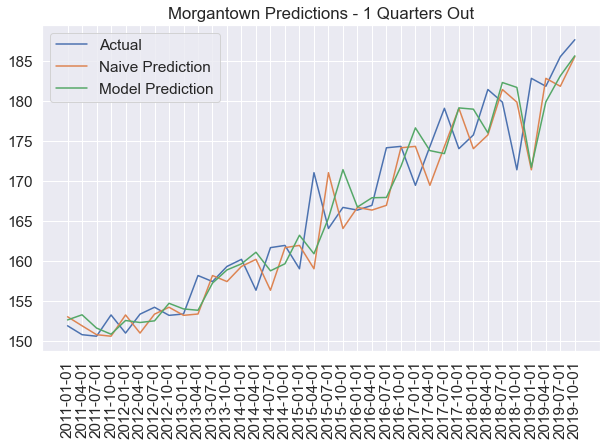

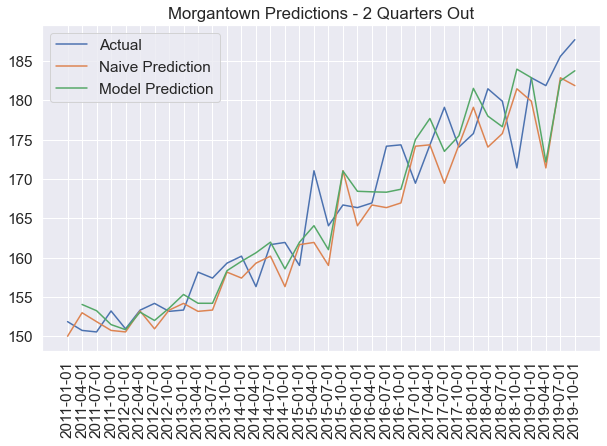

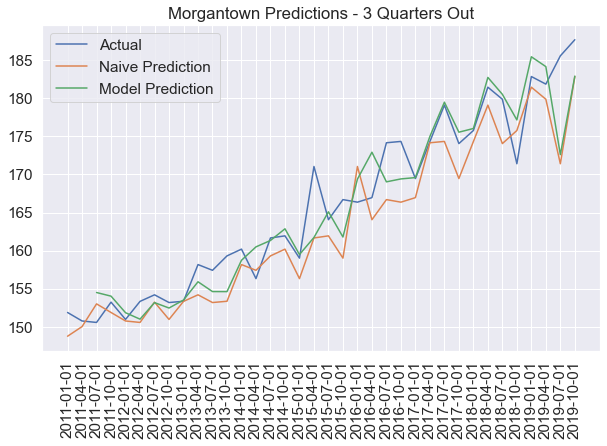

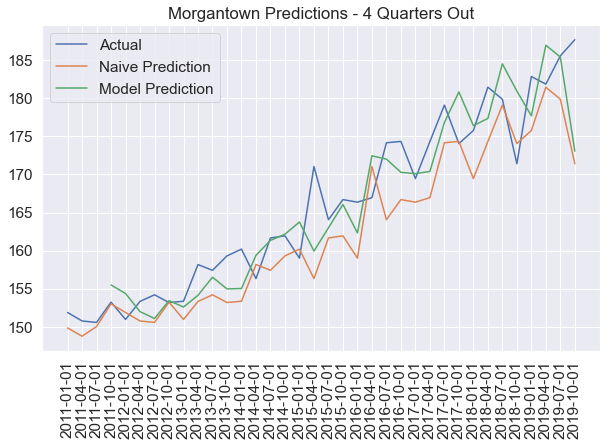

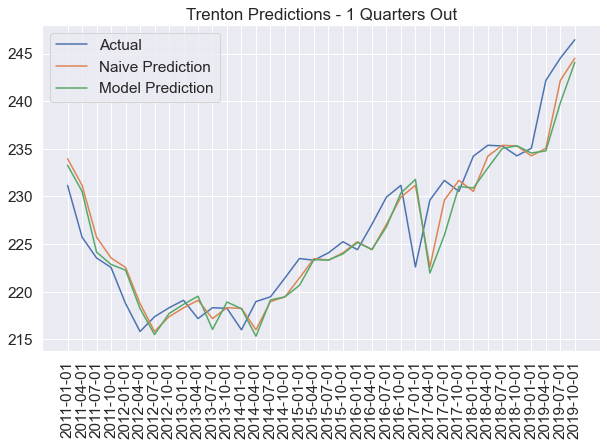

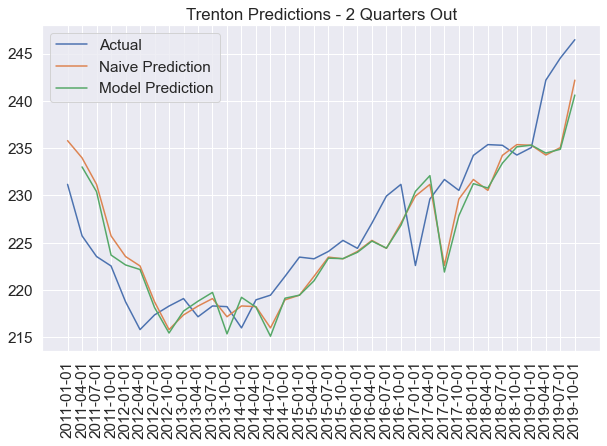

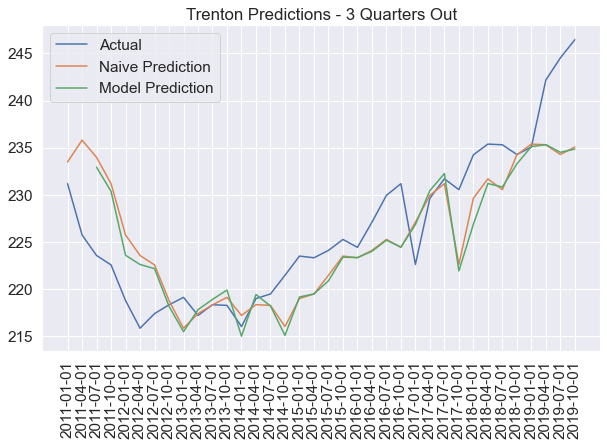

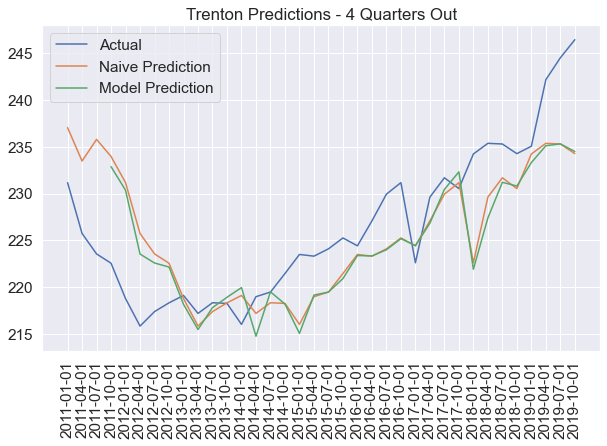

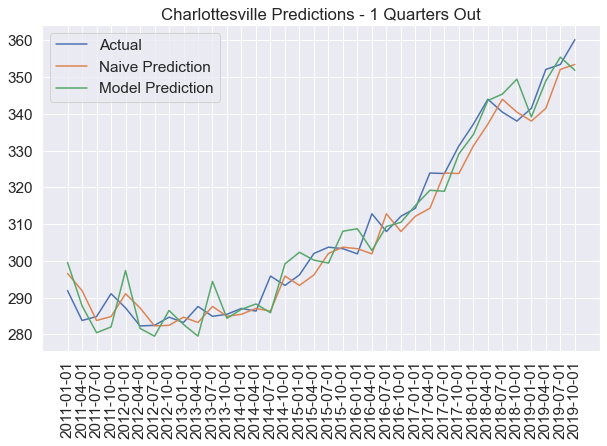

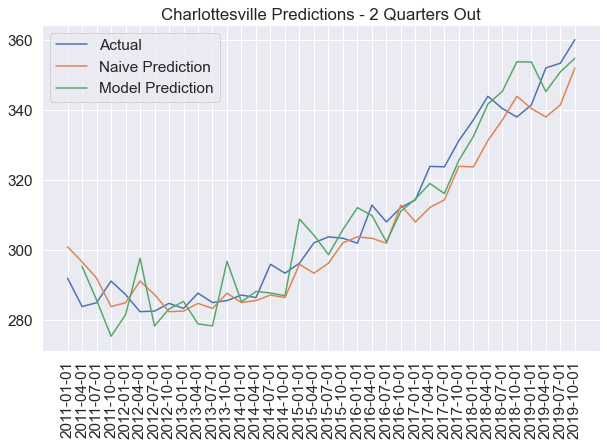

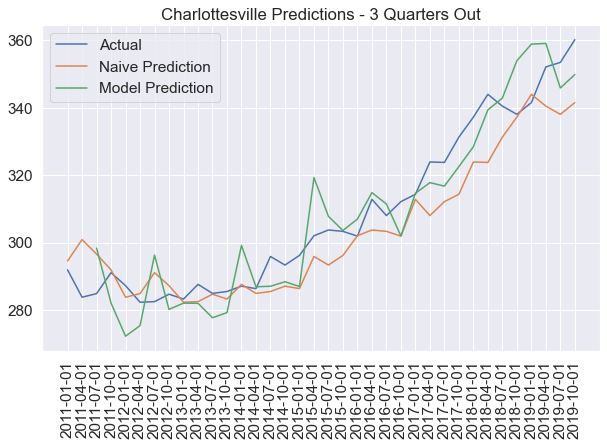

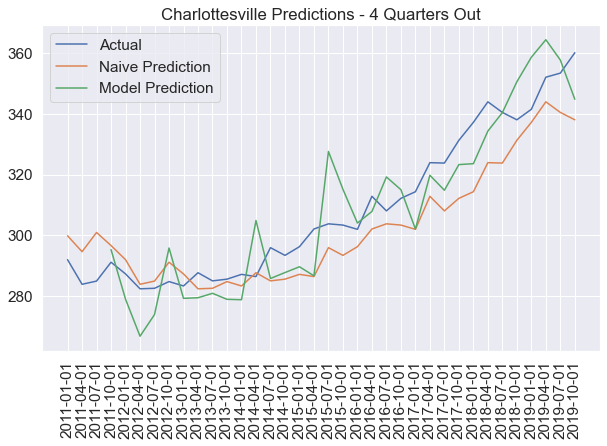

In [62]:
for city in best_model_results.sort_values('improvement_pct', ascending=False).tail(3).city:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.date, city_df.hpi,  label='Actual')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

"Improvement" here is a bit of a subjective metric when it is highly driven by the accuracy of the naive assumption, which is highly variant. Additionally, the combination of these winners and losers with the puse MSE winners and losers presents a pattern - the more volatile a city's HPI is quarter-to-quarter, the harder it is to predict. This can also be seen from the fact that in the worst-prediction cities, the model's prediction is very close to the naive assumption, which implies that the models don't learn anything and are simply defaulting to the easiest non-prediction: next quarter's HPI will be the same as today's. This dichotomy is not a huge shock, but is still an important observation.

The one notable exception here is Cincinnati, where there is high period-to-period fluctuation but a regular pattern of seasonality. Regular seasonality is a hugely helpful in time series predictions, so it makes sense that the only city to have it is also one of the easiest to predict.

**AIC**

In [28]:
best_model_results.sort_values('AIC').style.background_gradient(cmap = 'YlGnBu', gmap=best_model_results.AIC)

Top Cities

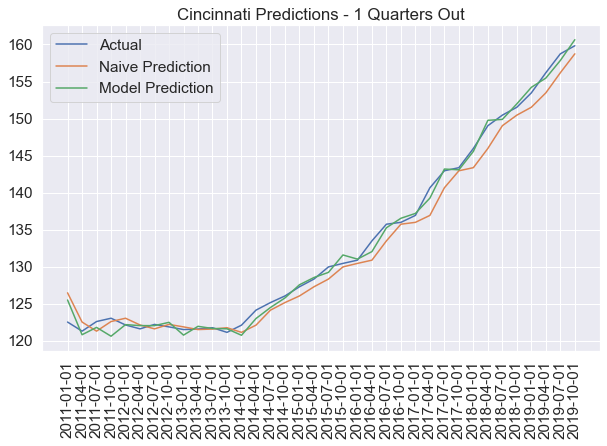

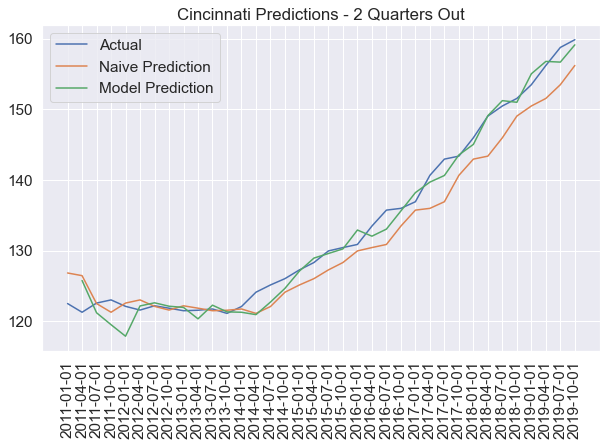

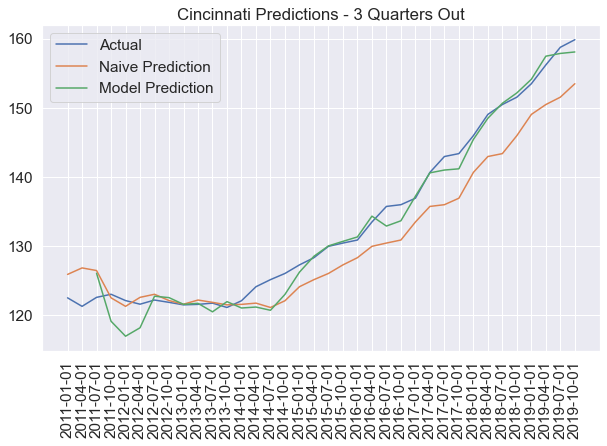

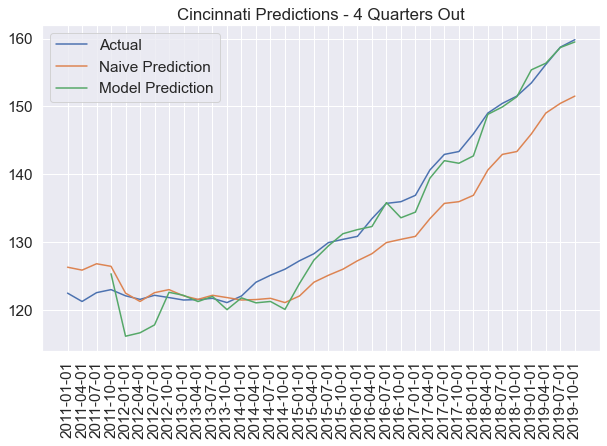

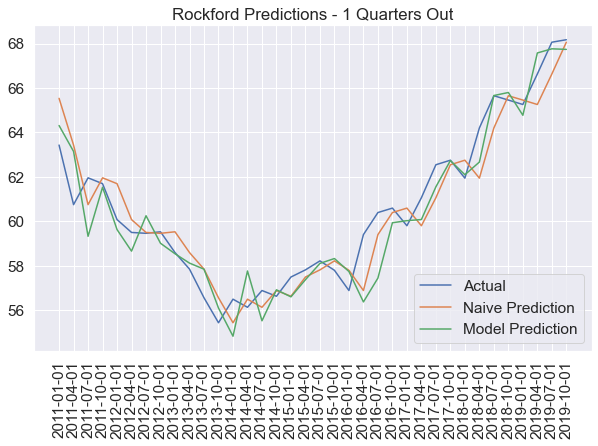

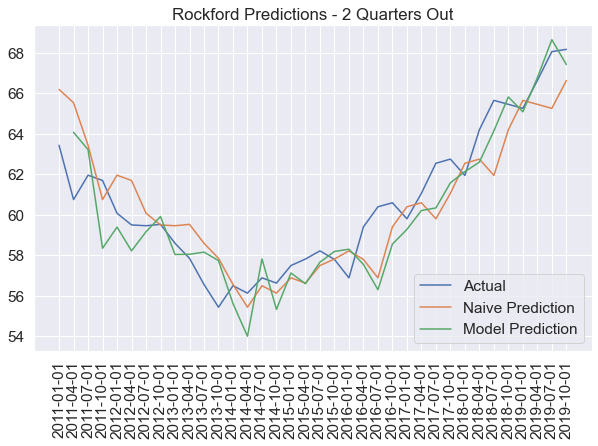

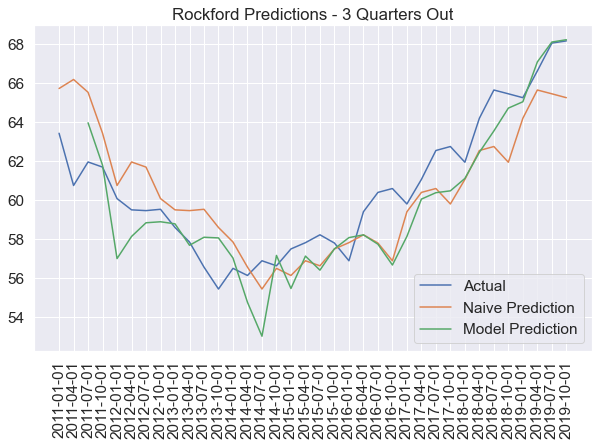

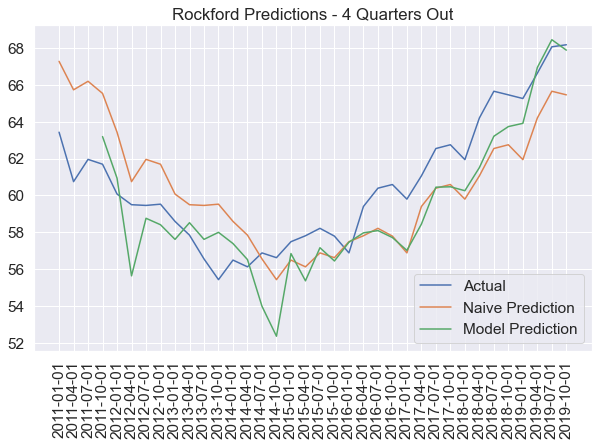

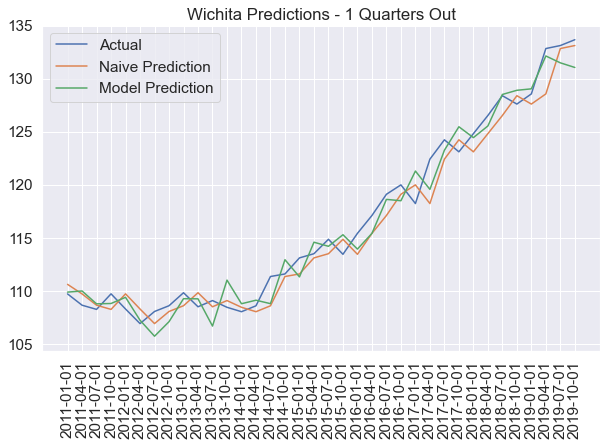

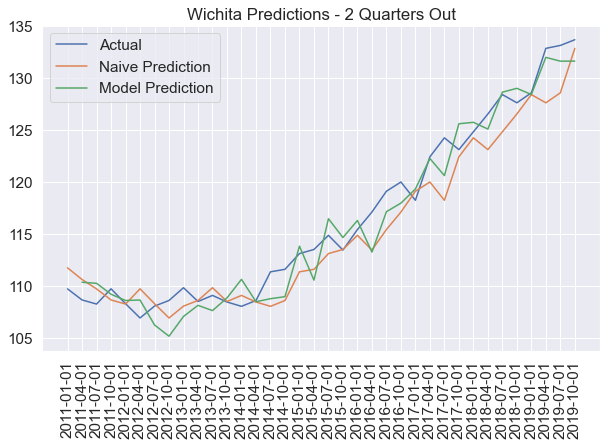

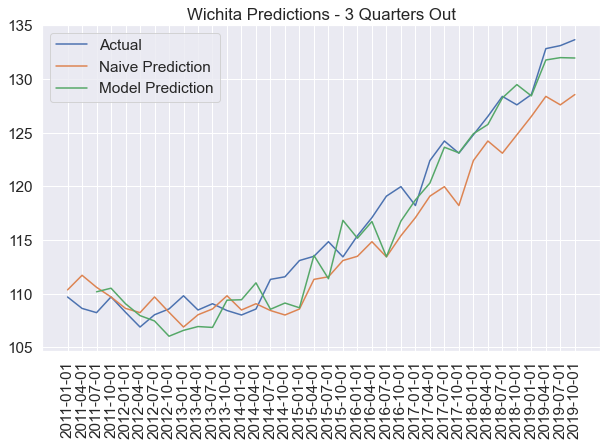

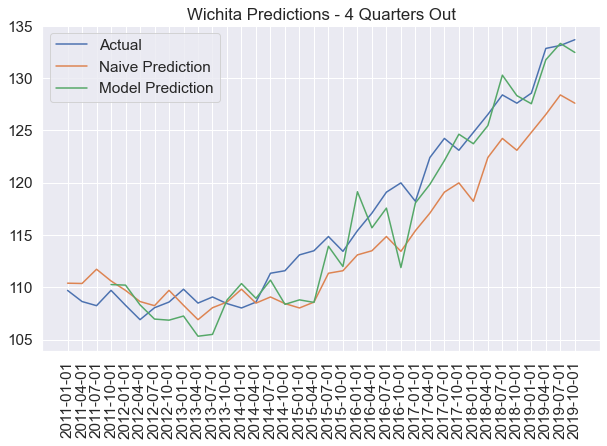

In [64]:
for city in best_model_results.sort_values('AIC').head(3).city:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.date, city_df.hpi,  label='Actual')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

Bottom Cities

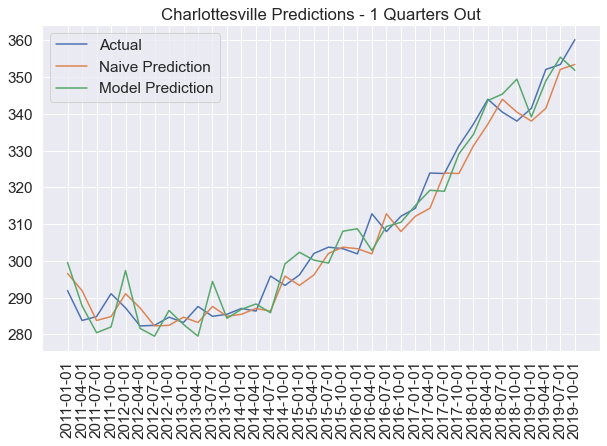

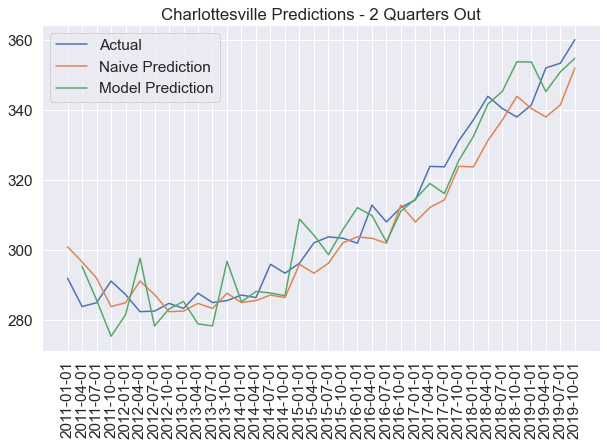

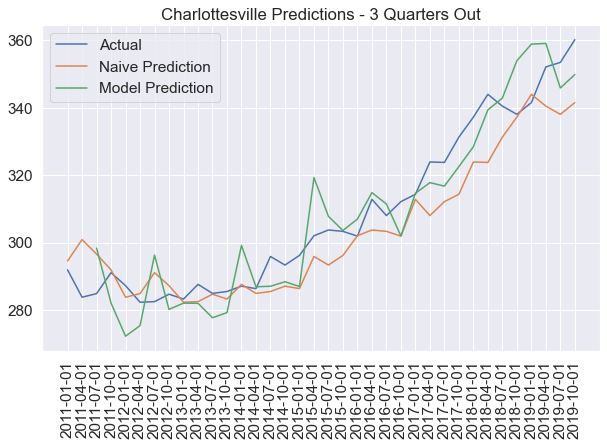

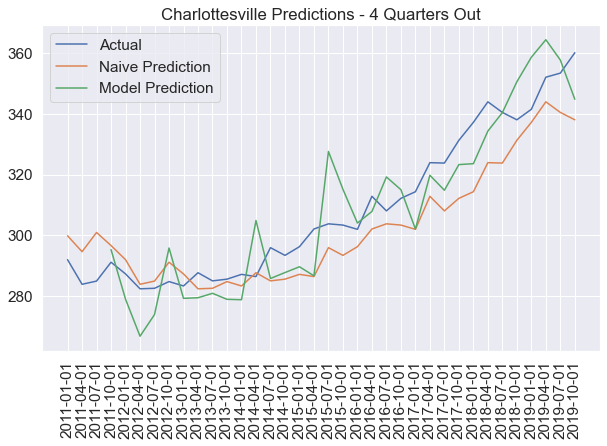

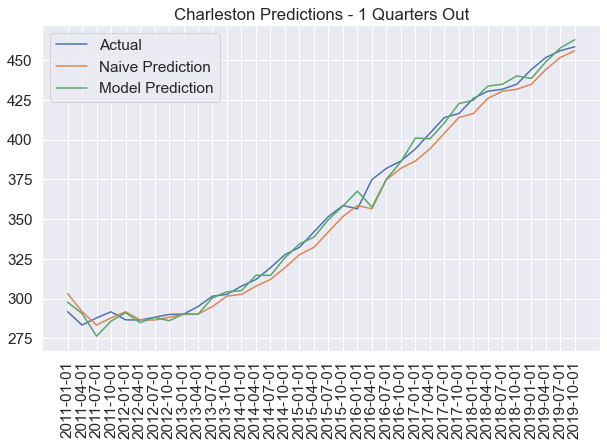

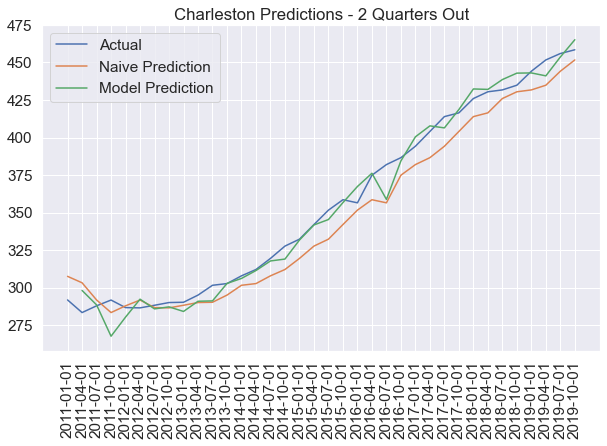

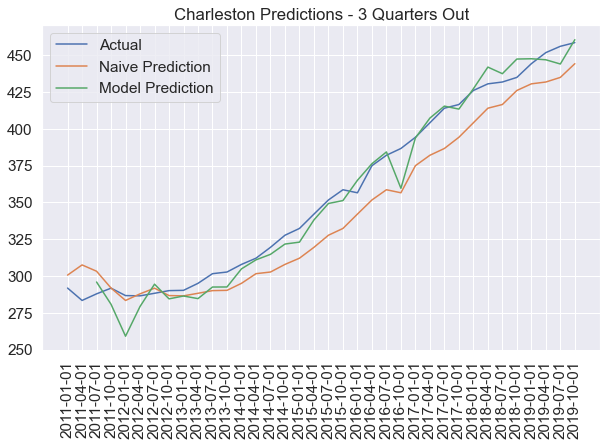

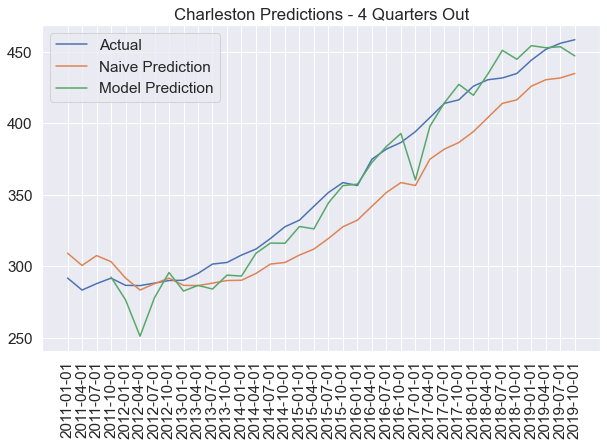

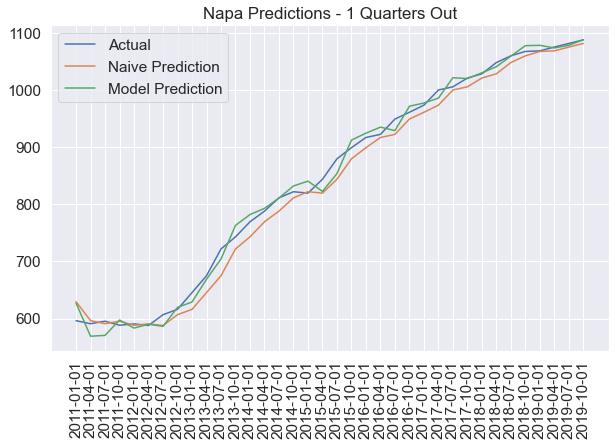

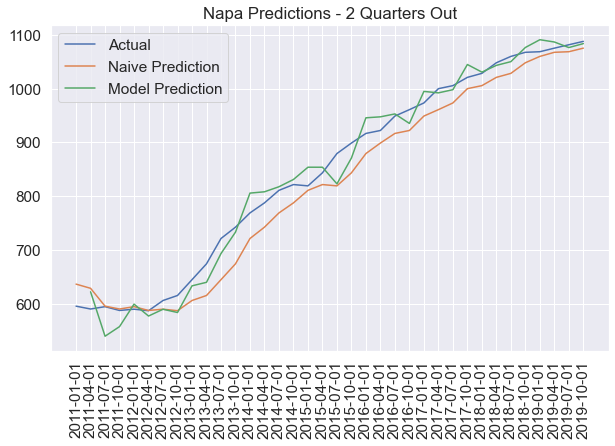

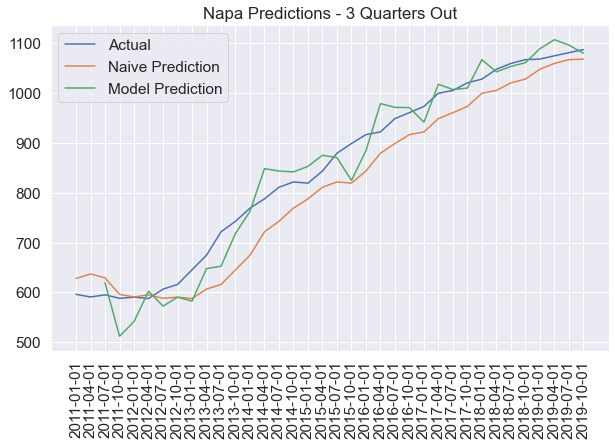

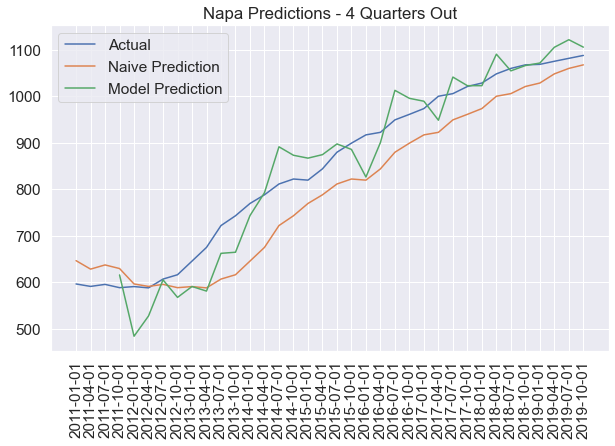

In [65]:
for city in best_model_results.sort_values('AIC').tail(3).city:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' + str(Q)
        plt.plot(city_df.date, city_df.hpi,  label='Actual')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

High performers on the metric of AIC don't necessarily provide spot-on predictions or win big over the naive assumption. Instead, they do a moderate (or in Cincinnati's case, great) job of predicting in cities that have a regular trend and high degree of seasonality. This is more a reflection of the "regularity" of the underlying time series, *not* of the model itself.

#### Gauging Uncertainty

**Adding secondary calculations relating to uncertainty**

In [35]:
best_results['pred_1_low'] = best_results.pred_1 - best_results.std_1
best_results['pred_2_low'] = best_results.pred_2 - best_results.std_2
best_results['pred_3_low'] = best_results.pred_3 - best_results.std_3
best_results['pred_4_low'] = best_results.pred_4 - best_results.std_4

best_results['pred_1_high'] = best_results.pred_1 + best_results.std_1
best_results['pred_2_high'] = best_results.pred_2 + best_results.std_2
best_results['pred_3_high'] = best_results.pred_3 + best_results.std_3
best_results['pred_4_high'] = best_results.pred_4 + best_results.std_4

In [75]:
std_cols = ['std_1', 'std_2', 'std_3', 'std_4']
pred_cols = ['pred_1', 'pred_2', 'pred_3', 'pred_4']
error_cols = ['error_' + str(x) for x in range(1,5)]
errors = pd.DataFrame(np.array(best_results[std_cols])/np.array(best_results[pred_cols]), columns=error_cols)

In [92]:
best_model_results['uncertainty'] = list(pd.concat([best_results, errors], axis=1).groupby(['city'])[error_cols].mean().mean(axis=1))

**Re-exploring correlations**

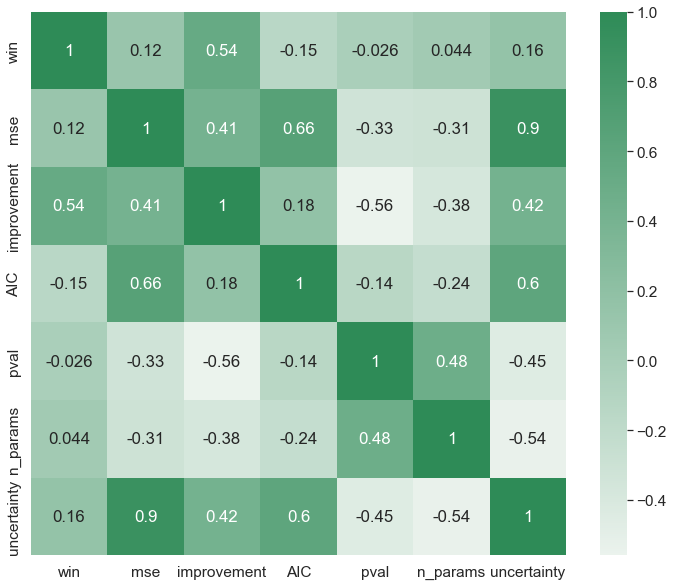

In [96]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(best_model_results.iloc[:, 4:].corr(), annot=True, cmap=sns.light_palette("seagreen", as_cmap=True))
plt.show()

Uncertainty seems to be highly correlated with our previously identified success metrics like MSE and AIC. Let's see how often actual values fall within the predicted margin of error.

In [116]:
low_cols = ['pred_' + str(x) + '_low' for x in range(1,5)]
high_cols = ['pred_' + str(x) + '_high' for x in range(1,5)]
too_low = (np.array(best_results.hpi).reshape(720,1) < np.array(best_results[low_cols]))
too_high = (np.array(best_results.hpi).reshape(720,1) > np.array(best_results[high_cols]))

In [130]:
oor_cols = ['oor_' + str(x) for x in range (1,5)]
out_of_range = pd.DataFrame(too_low + too_high, columns=oor_cols)

In [159]:
oor_rate = pd.concat([best_results, out_of_range], axis=1).groupby(['city'])[oor_cols].mean().mean(axis=1).to_frame('oor_rate')

In [160]:
avg_uncertainty = best_model_results[['city', 'uncertainty']].set_index(['city']).uncertainty

In [170]:
uncertainty_oor = pd.concat([avg_uncertainty, oor_rate], axis=1).sort_values('uncertainty')
uncertainty_oor.style.background_gradient(cmap = 'YlGnBu', axis=0)

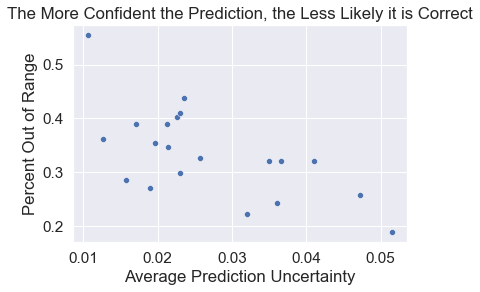

In [156]:
sns.scatterplot(avg_uncertainty, oor_rate)
plt.title('The More Confident the Prediction, the Less Likely it is Correct')
plt.xlabel('Average Prediction Uncertainty')
plt.ylabel('Percent Out of Range')
plt.show()

In [173]:
uncertainty_oor.head(3).index

Index(['Wichita', 'Lincoln', 'Cincinnati'], dtype='object', name='city')

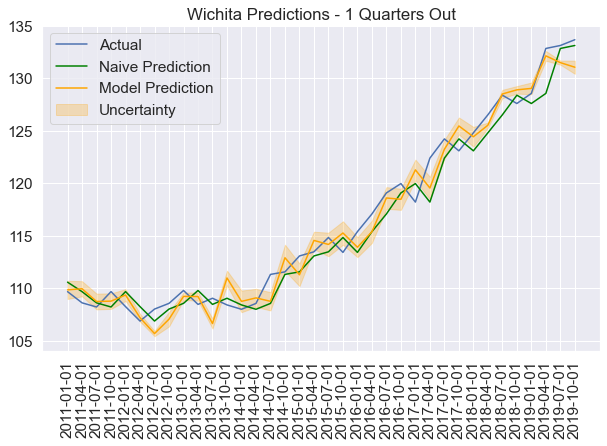

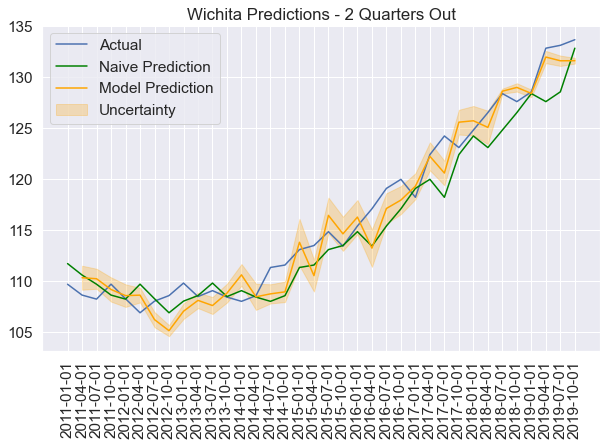

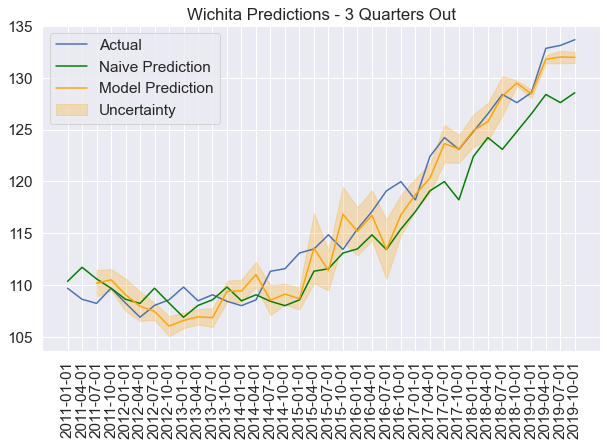

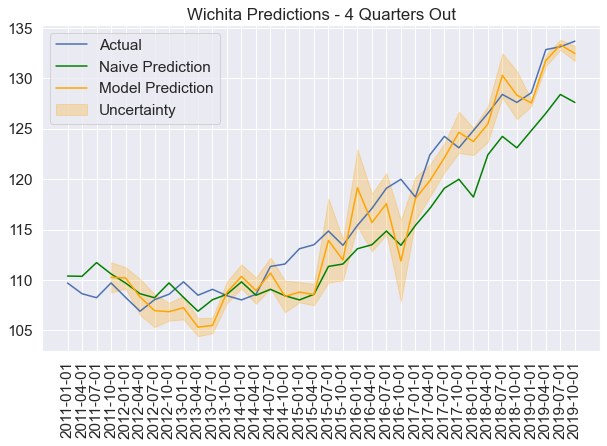

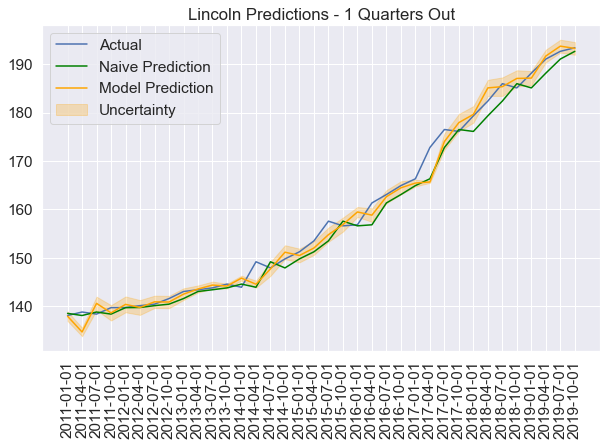

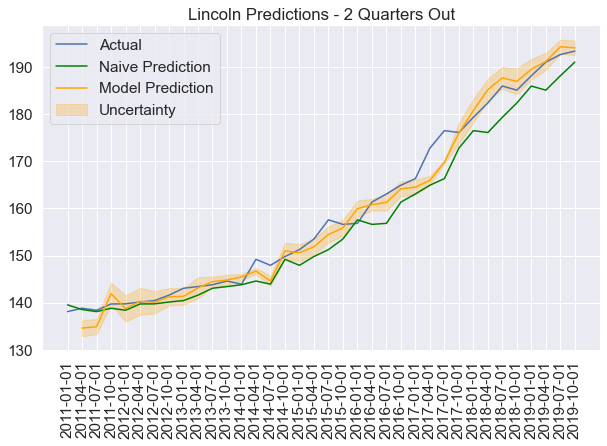

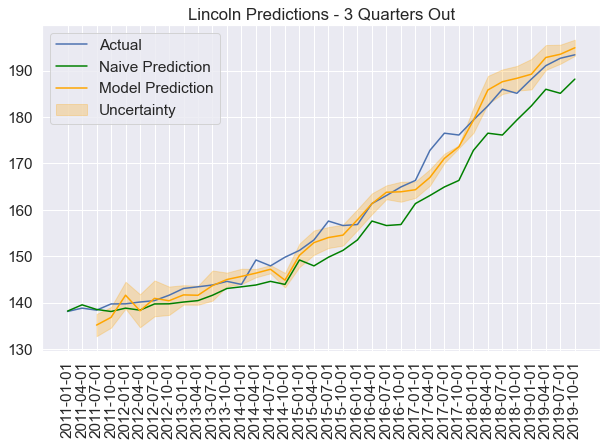

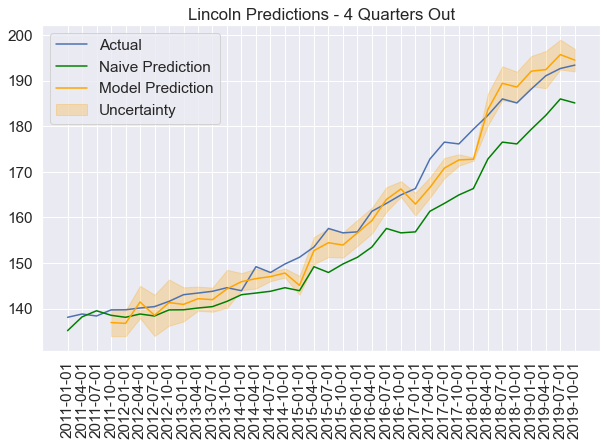

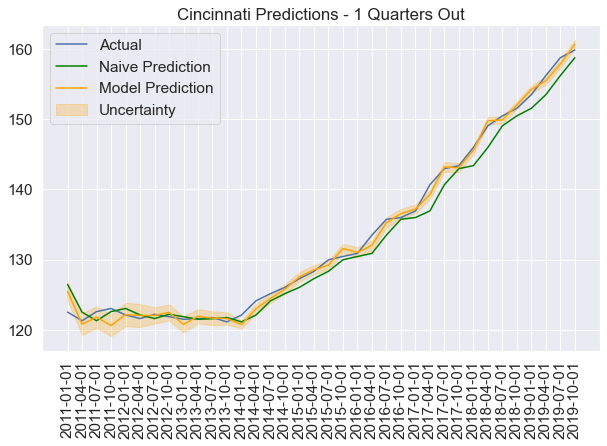

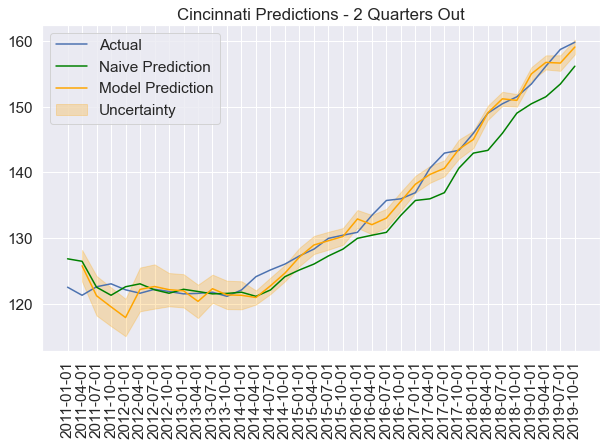

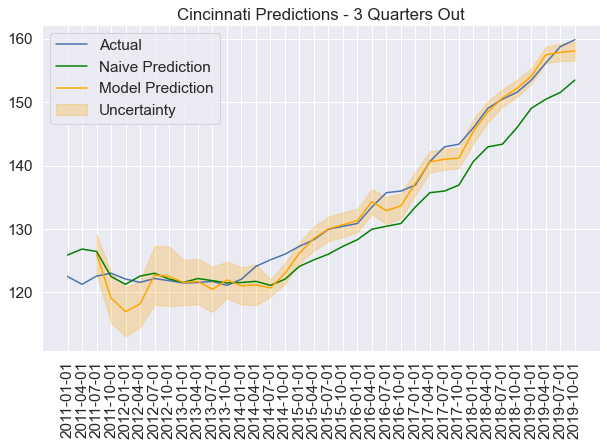

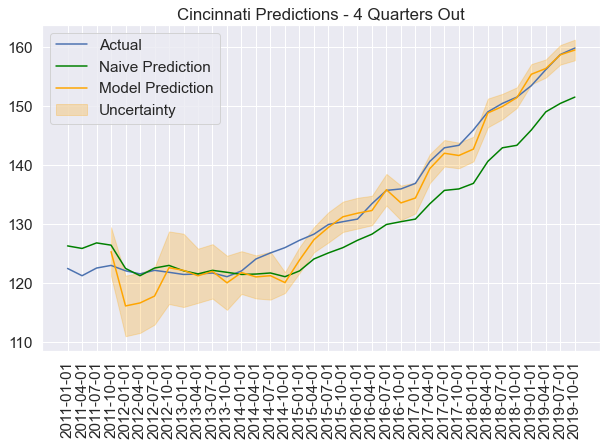

In [178]:
for city in uncertainty_oor.head(3).index:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' +  str(Q)
        pred_low = 'pred_' + str(Q) + '_low'
        pred_high = 'pred_' + str(Q) + '_high'
        plt.plot(city_df.date, city_df.hpi,  label='Actual', color='b')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction', color='green')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction', color='orange')
        plt.fill_between(city_df.date, city_df[pred_high], city_df[pred_low], label='Uncertainty', alpha=0.25, color='orange')
        #plt.plot(city_df.date, city_df[pred_high], label='High Estimate')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

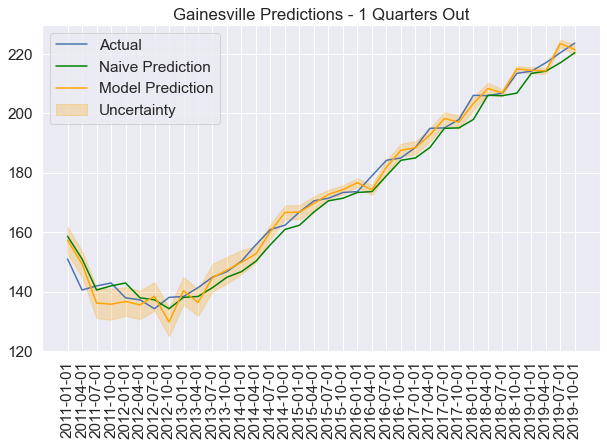

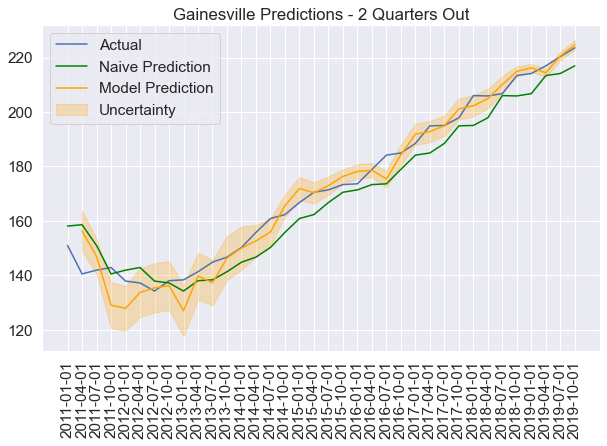

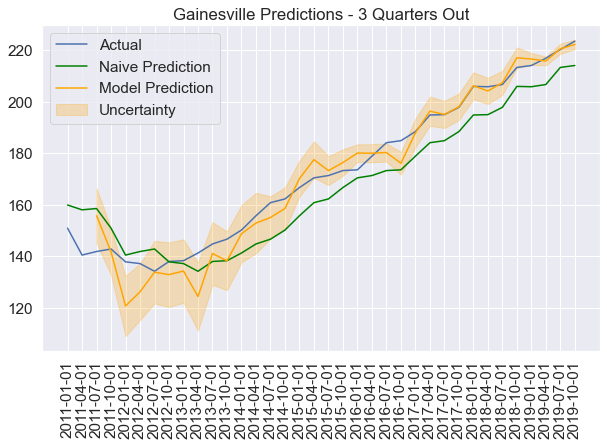

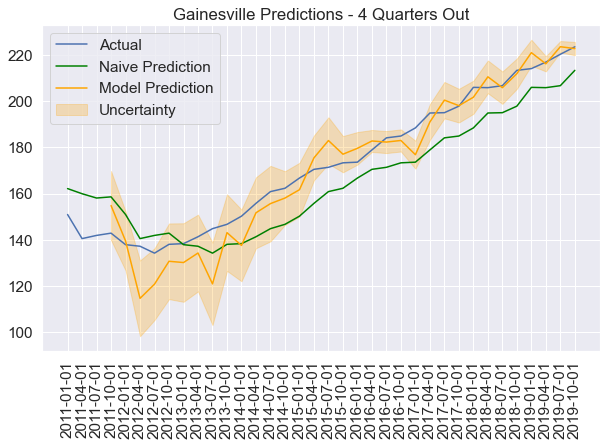

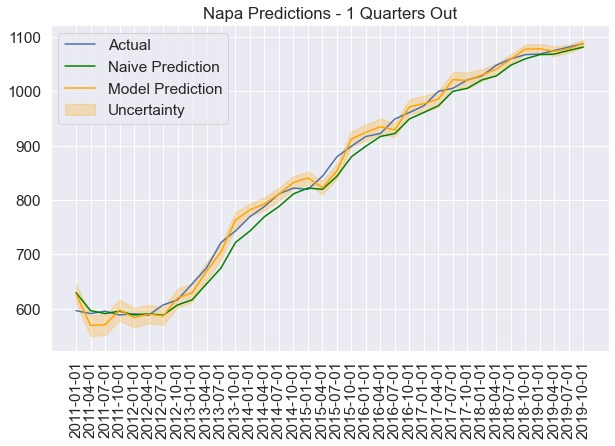

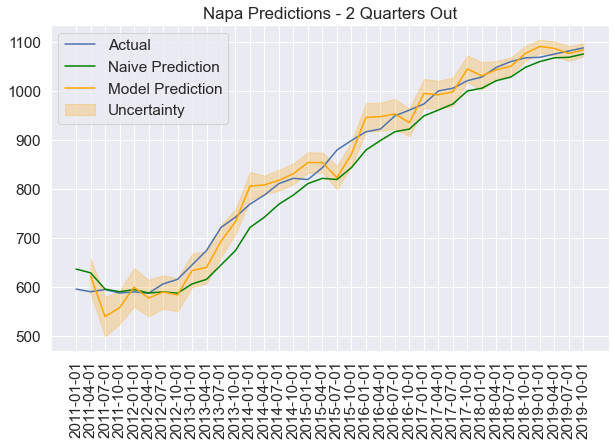

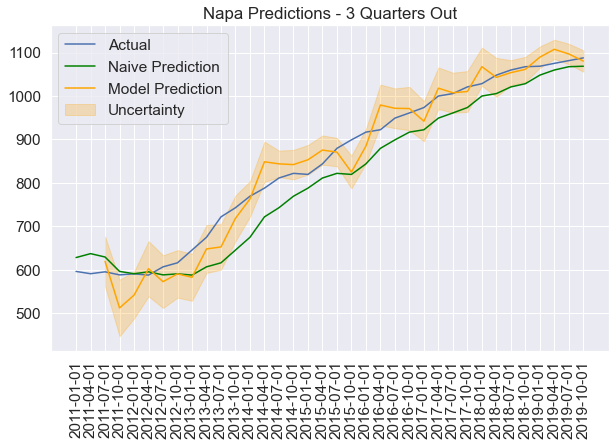

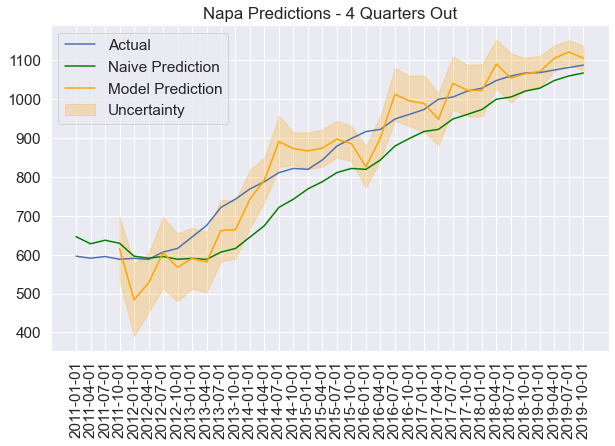

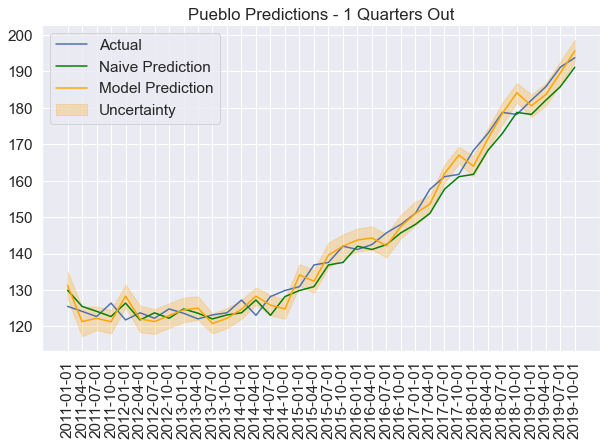

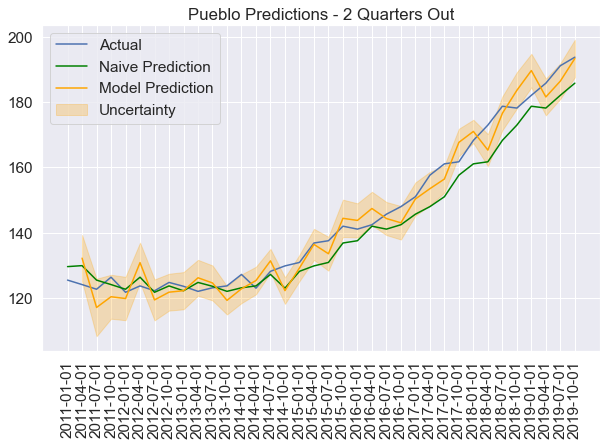

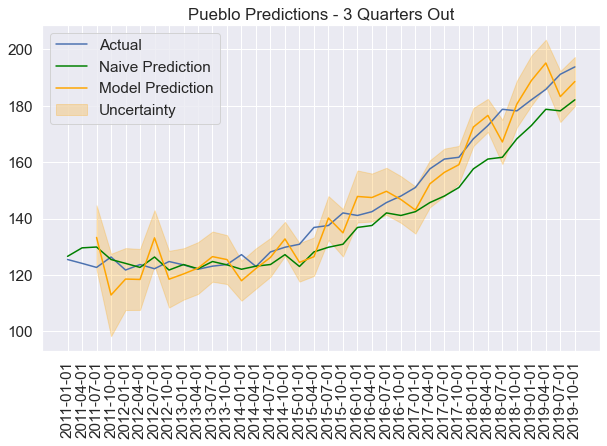

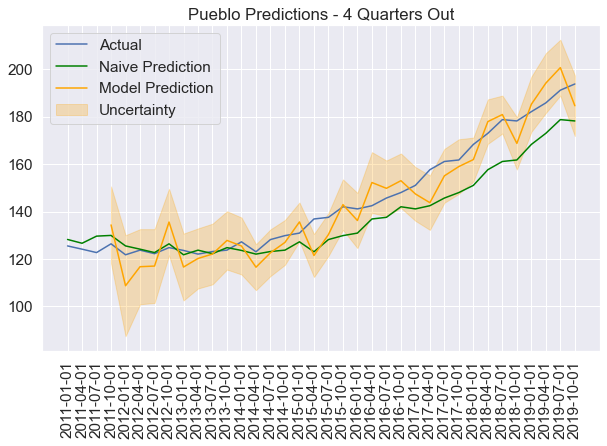

In [177]:
for city in uncertainty_oor.tail(3).index:
    city_df = best_results[best_results.city==city]
    for Q in range(1, 5):
        plt.figure(figsize=(10,6))
        naive_col = 'naive_' + str(Q)
        pred_col = 'pred_' +  str(Q)
        pred_low = 'pred_' + str(Q) + '_low'
        pred_high = 'pred_' + str(Q) + '_high'
        std_col = ''
        plt.plot(city_df.date, city_df.hpi,  label='Actual', color='b')
        plt.plot(city_df.date, city_df[naive_col], label='Naive Prediction', color='green')
        plt.plot(city_df.date, city_df[pred_col], label='Model Prediction', color='orange')
        plt.fill_between(city_df.date, city_df[pred_high], city_df[pred_low], label='Uncertainty', alpha=0.25, color='orange')
        #plt.plot(city_df.date, city_df[pred_high], label='High Estimate')
        plt.xticks(rotation=90)
        plt.legend()
        plt.title(f'{city} Predictions - {str(Q)} Quarters Out')
        plt.show()

**"Bad" models seem to understand their limitations, while the best models tend to be overconfident.**

#### The Winner - Cincinnati

Cincinnati's trend is nuanced, but the model picks up on it well even a year out.

#### The Loser - Napa

Napa has a pretty simple and steady HPI trend, but ARIMA models were unable to pick up on it multiple periods out.

#### Question 3 - How much is HPI driven by intrinsic trends?

It depends on the city. In some places like Cincinnati, it's fairly predictable. In others, like Kennewick, it's basically a straight line, so it's uncertain how much an autoregressive model is actually needed. In others still, like Napa, it's all over the place.

This could be related to the way it's reported in different cities, or to the underlying volatility of the housing markets themselves.

We will explore this further when we take into account economic and demographic variables.

### Using Facebook's Prophet Algorithm

*Facebook's "prophet" algorithm uses an additive model to provide a forecast for univariate time series, comprised of trend, seasonality, and holidays, and is intended to automatically optimize hyperparamters. I am skeptical that it will be able to get very accurate results on this dataset due to the quarterly reporting cadende, which makes detecting seasonality and holidays difficult.*